# Vary the grid offset

We use the "continuous" pro-hotspot prediction method.  Compare the two data sets (original, and redistributed) to see how the hit rate varies as we change the grid offset.

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import bz2, pickle, io, datetime, collections
import open_cp.prohotspot
import open_cp.scripted
import open_cp.scripted.analysis as analysis

In [2]:
with bz2.open("points1.pic.bz") as f:
    points = pickle.load(f)

with bz2.open("geo.pic.bz") as f:
    geo = pickle.load(f)

In [4]:
def calculate_with_random_offsets(grid_size=150, space=1, time=70):
    all_betas = {}
    for _ in range(50):
        memfile = io.StringIO()
        xo = np.random.randint(0, grid_size)
        yo = np.random.randint(0, grid_size)
        grid = open_cp.data.Grid(xsize=grid_size, ysize=grid_size, xoffset=xo, yoffset=yo)
        with open_cp.scripted.Data(lambda : points, lambda : geo,
                start=datetime.datetime(2007,1,1), grid=grid) as state:

            time_range = open_cp.scripted.TimeRange(datetime.datetime(2007,10,1),
                    datetime.datetime(2008,1,1), datetime.timedelta(days=1))
            weight = open_cp.prohotspot.ClassicWeight(space, time)
            state.add_prediction(open_cp.scripted.ProHotspotCtsProvider(weight, 150), time_range)

            state.score(open_cp.scripted.HitCountEvaluator)
            state.process(open_cp.scripted.HitCountSave(memfile))
        all_betas[(xo,yo)] = analysis.hit_counts_to_beta(io.StringIO(memfile.getvalue()))
    return all_betas

def plot_medians_and_box_plot(all_betas, axes=None):
    keys = list(all_betas)
    coverages = list(range(1, 21))
    medians = {key : { c : next(iter(all_betas[key].values()))[c].median() for c in coverages}
               for key in keys}

    if axes is None:
        fig, axes = plt.subplots(ncols=2, figsize=(16,8))
    else:
        fig = None

    ax = axes[0]
    for key in keys:
        y = [medians[key][c] for c in coverages]
        ax.plot(coverages, y, linewidth=0.5, color="black", alpha=0.5)
    ax.set_title("Hit rate curves")

    ax = axes[1]
    data = []
    for c in coverages:
        data.append([medians[key][c] for key in keys])
    ax.boxplot(data)
    ax.set_title("Box plot")

    for ax in axes:
        ax.set(xlabel="Coverages (%)", ylabel="Hit rate (fraction)")
    
    return fig

In [4]:
all_betas = calculate_with_random_offsets()

with bz2.open("results.pic.bz", "wb") as f:
    pickle.dump(all_betas, f)

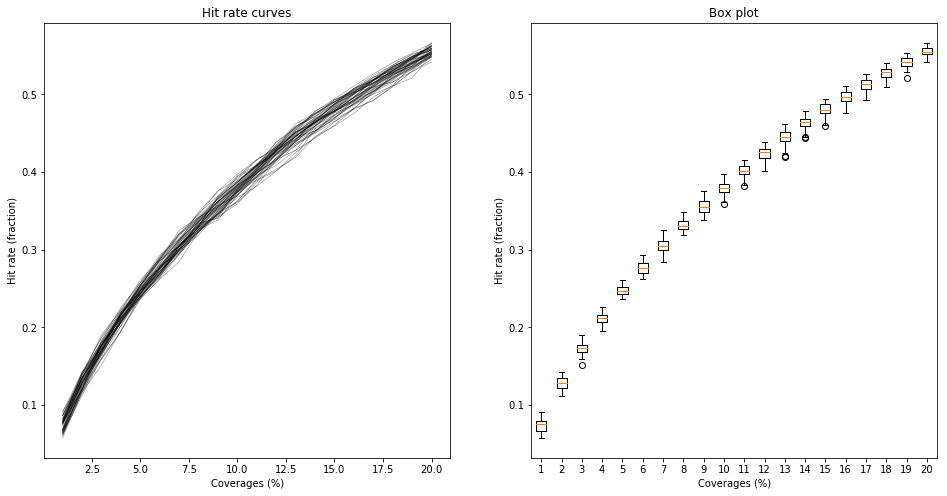

In [5]:
fig = plot_medians_and_box_plot(all_betas)

And the same again, with the redistributed data.

In [6]:
with bz2.open("points2.pic.bz") as f:
    points = pickle.load(f)

In [10]:
all_betas = calculate_with_random_offsets()

with bz2.open("results2.pic.bz", "wb") as f:
    pickle.dump(all_betas, f)

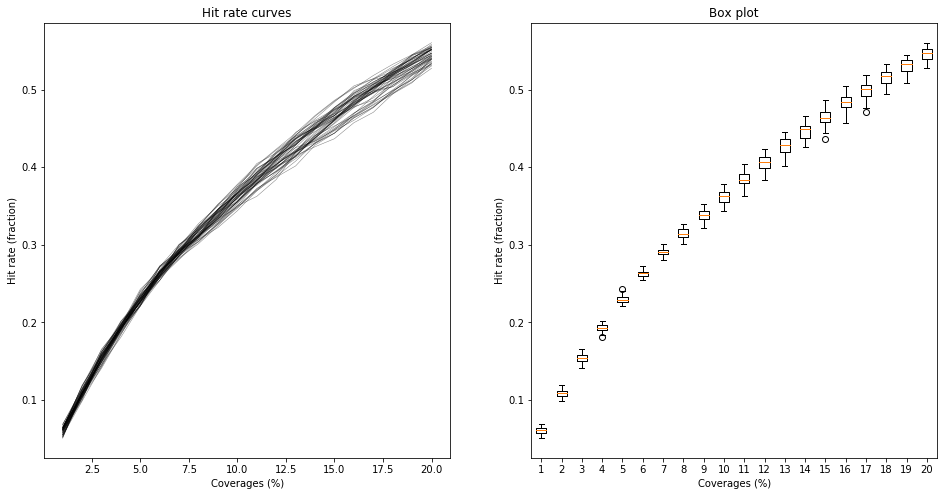

In [8]:
fig = plot_medians_and_box_plot(all_betas)

And the same again, with the building redistributed data.

In [4]:
with bz2.open("points3.pic.bz") as f:
    points = pickle.load(f)

In [6]:
all_betas = calculate_with_random_offsets()

with bz2.open("results3.pic.bz", "wb") as f:
    pickle.dump(all_betas, f)

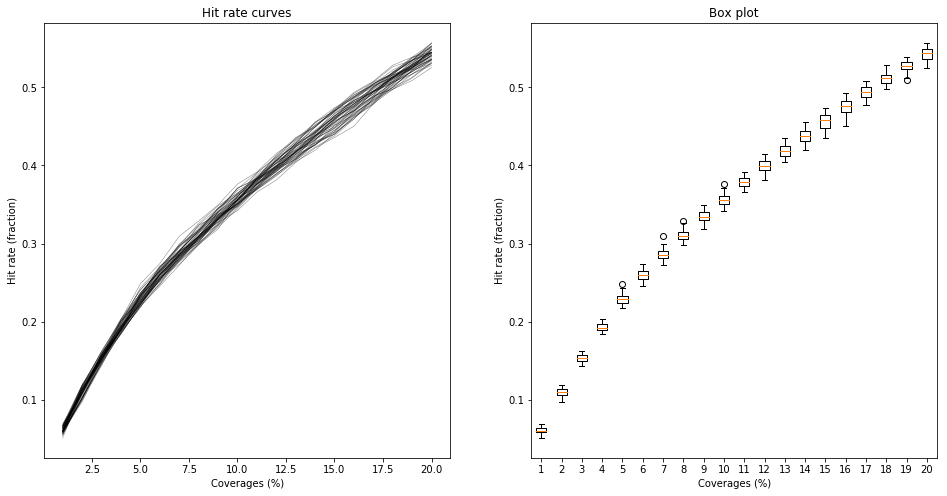

In [7]:
fig = plot_medians_and_box_plot(all_betas)

## Plot for paper

In [2]:
with bz2.open("results.pic.bz", "rb") as f:
    all_betas1 = pickle.load(f)
with bz2.open("results2.pic.bz", "rb") as f:
    all_betas2 = pickle.load(f)
with bz2.open("results3.pic.bz", "rb") as f:
    all_betas3 = pickle.load(f)

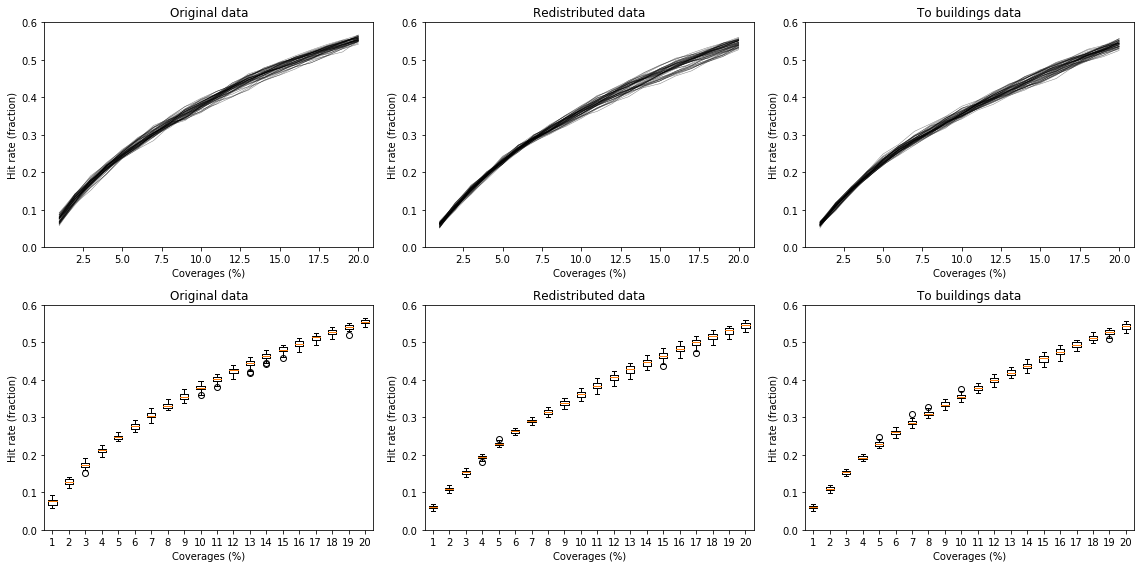

In [5]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(16,8))

plot_medians_and_box_plot(all_betas1, [axes[0][0], axes[1][0]])
plot_medians_and_box_plot(all_betas2, [axes[0][1], axes[1][1]])
plot_medians_and_box_plot(all_betas3, [axes[0][2], axes[1][2]])

for ax in axes.flat:
    ax.set(ylim=[0,0.6])
for ax in axes[:,0]:
    ax.set_title("Original data")
for ax in axes[:,1]:
    ax.set_title("Redistributed data")
for ax in axes[:,2]:
    ax.set_title("To buildings data")
fig.tight_layout()

In [44]:
def to_medians_by_coverage(all_betas1):
    by_coverage = collections.defaultdict(list)
    for key in all_betas1:
        k = list(all_betas1[key])[0]
        for cov in all_betas1[key][k]:
            dist = all_betas1[key][k][cov]
            by_coverage[cov].append(dist.median())
    return dict(by_coverage)

by_coverage1 = to_medians_by_coverage(all_betas1)
by_coverage2 = to_medians_by_coverage(all_betas2)
by_coverage3 = to_medians_by_coverage(all_betas3)

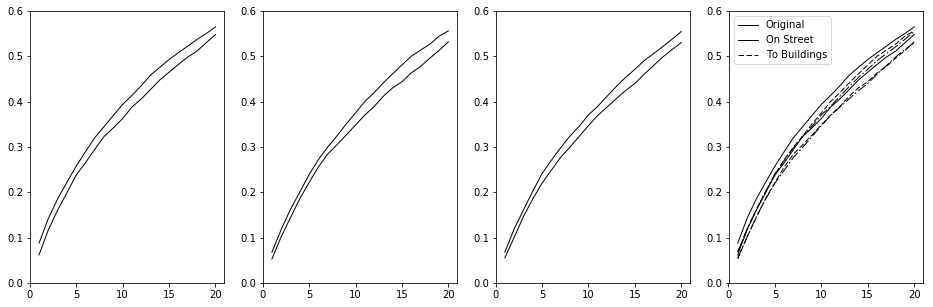

In [55]:
fig, axes = plt.subplots(ncols=4, figsize=(16,5))

x = list(range(1, 21))
for ax, bc in zip(axes, [by_coverage1, by_coverage2, by_coverage3]):
    y = [np.percentile(bc[t], 5) for t in x]
    ax.plot(x, y, linewidth=1, color="black")
    y = [np.percentile(bc[t], 95) for t in x]
    ax.plot(x, y, linewidth=1, color="black")
    ax.set(ylim=[0, 0.6])
    
ax = axes[3]
ax.set(ylim=[0, 0.6])
for bc, ls in zip([by_coverage1, by_coverage2, by_coverage3], ["-", "--", "-."]):
    y = [np.percentile(bc[t], 5) for t in x]
    ax.plot(x, y, linewidth=1, color="black", linestyle=ls)
    y = [np.percentile(bc[t], 95) for t in x]
    ax.plot(x, y, linewidth=1, color="black", linestyle=ls)
ax.legend(["Original", "On Street", "To Buildings"])

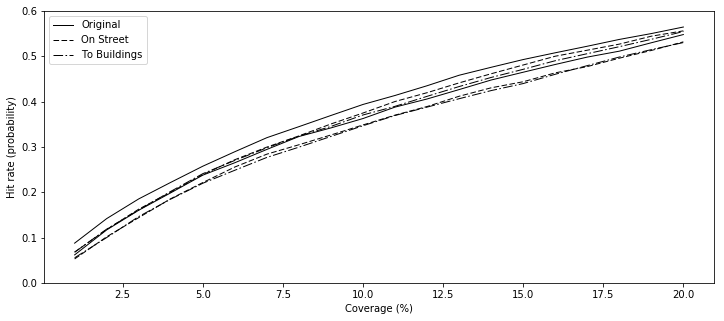

In [61]:
fig, ax = plt.subplots(figsize=(12,5))

ax.set(ylim=[0, 0.6])
for bc, ls, la in zip([by_coverage1, by_coverage2, by_coverage3], ["-", "--", "-."],
                     ["Original", "On Street", "To Buildings"]):
    y = [np.percentile(bc[t], 5) for t in x]
    ax.plot(x, y, linewidth=1, color="black", linestyle=ls, label=la)
    y = [np.percentile(bc[t], 95) for t in x]
    ax.plot(x, y, linewidth=1, color="black", linestyle=ls, label="_none")
ax.legend()
ax.set(xlabel="Coverage (%)", ylabel="Hit rate (probability)")
None

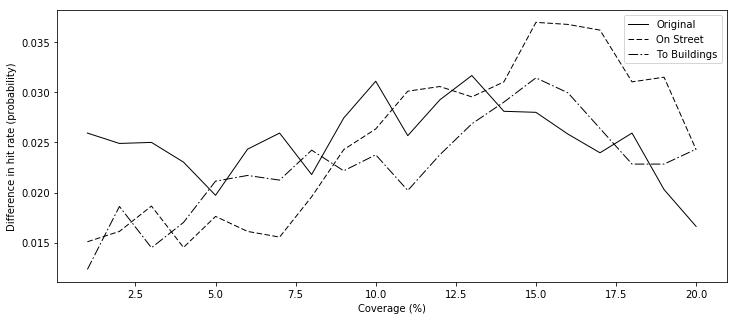

In [64]:
fig, ax = plt.subplots(figsize=(12,5))

for bc, ls, la in zip([by_coverage1, by_coverage2, by_coverage3], ["-", "--", "-."],
                     ["Original", "On Street", "To Buildings"]):
    y = [np.percentile(bc[t], 95) - np.percentile(bc[t], 5) for t in x]
    ax.plot(x, y, linewidth=1, color="black", linestyle=ls, label=la)
ax.legend()
ax.set(xlabel="Coverage (%)", ylabel="Difference in hit rate (probability)")
None

In [65]:
fig.savefig("../article/hit_rates_grid_vary.pdf")